# 1. Imports

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style="whitegrid")
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
import re

# 2. Load and Check Data

In [170]:
train_df = pd.read_csv('/home/david/Titanic/train.csv', index_col='PassengerId')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


We have missing values in Age, Cabin and Embarked variables. Missing values in Age will be filled by KNN Mean Imputation. Cabin will not be used in this analysis as it contains too many missing values. With regard to Embarked, we are now going to infer the two missing values by looking at the data. 

In [171]:
train_df[train_df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We can see that these two passengers shared Cabin and belonged to Pclass 1, so it seems a sensible approach to fill the two missing values with the most common value of Embarked among people belonging to Pclass 1.

In [172]:
train_df.loc[(train_df.Pclass == 1) & (train_df.Sex == 'female'), 'Embarked'].mode()

0    S
dtype: object

In [173]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


In [174]:
test_df = pd.read_csv('/home/david/Titanic/test.csv', index_col='PassengerId')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB
None


In the test set there are several missing values in Age and only one in Fare. The latter will be filled with the median value, while the former values will be filled using KNN mean imputation. Cabin will not be used in the analysis

In [175]:
median_fare_test = test_df['Fare'].median()
test_df['Fare'] = test_df['Fare'].fillna(median_fare_test)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        418 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB
None


# 3. EDA

## 3.1. Pclass Analysis

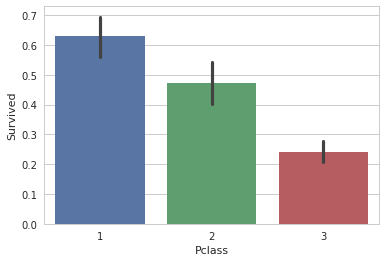

In [176]:
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.show()

In [177]:
train_df[['Pclass', 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


## 3.2. Sex Analysis

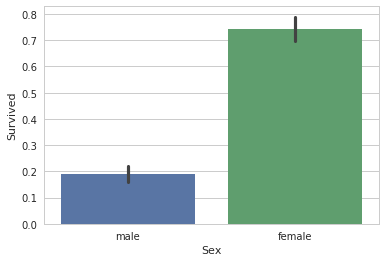

In [178]:
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.show()

In [179]:
train_df[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


## 3.3. Embarked Analysis

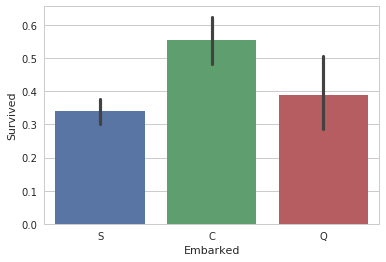

In [180]:
sns.barplot(x='Embarked', y='Survived', data=train_df)
plt.show()

In [181]:
train_df[['Embarked', 'Survived']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


## 3.4. Pclass-Sex Analysis

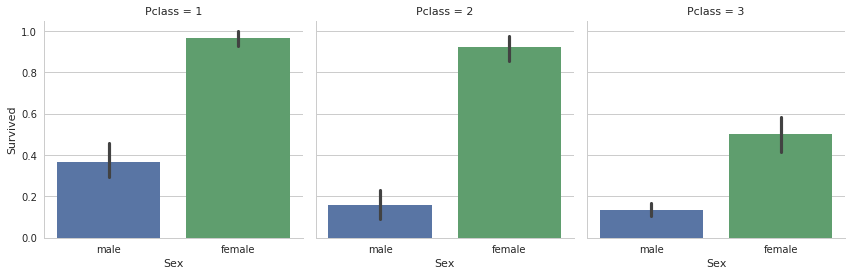

In [182]:
sns.factorplot(x='Sex', y='Survived', data=train_df, col='Pclass', kind='bar')
plt.show()

## 3.5. Pclass-Embarked Analysis

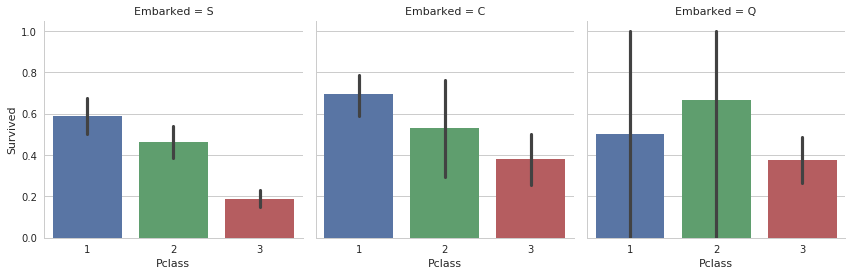

In [183]:
sns.factorplot(x='Pclass', y='Survived', data=train_df, col='Embarked', kind='bar')
plt.show()

## 3.6. Embarked-Sex Analysis

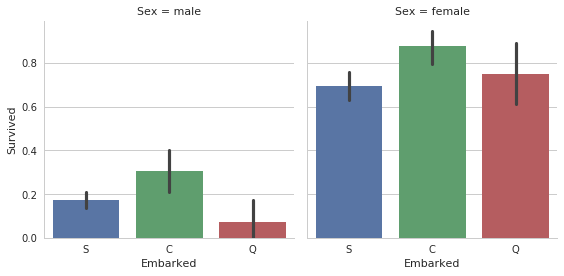

In [184]:
sns.factorplot(x='Embarked', y='Survived', data=train_df, col='Sex', kind='bar')
plt.show()

## 3.7. Sex-Pclass-Embarked Analysis

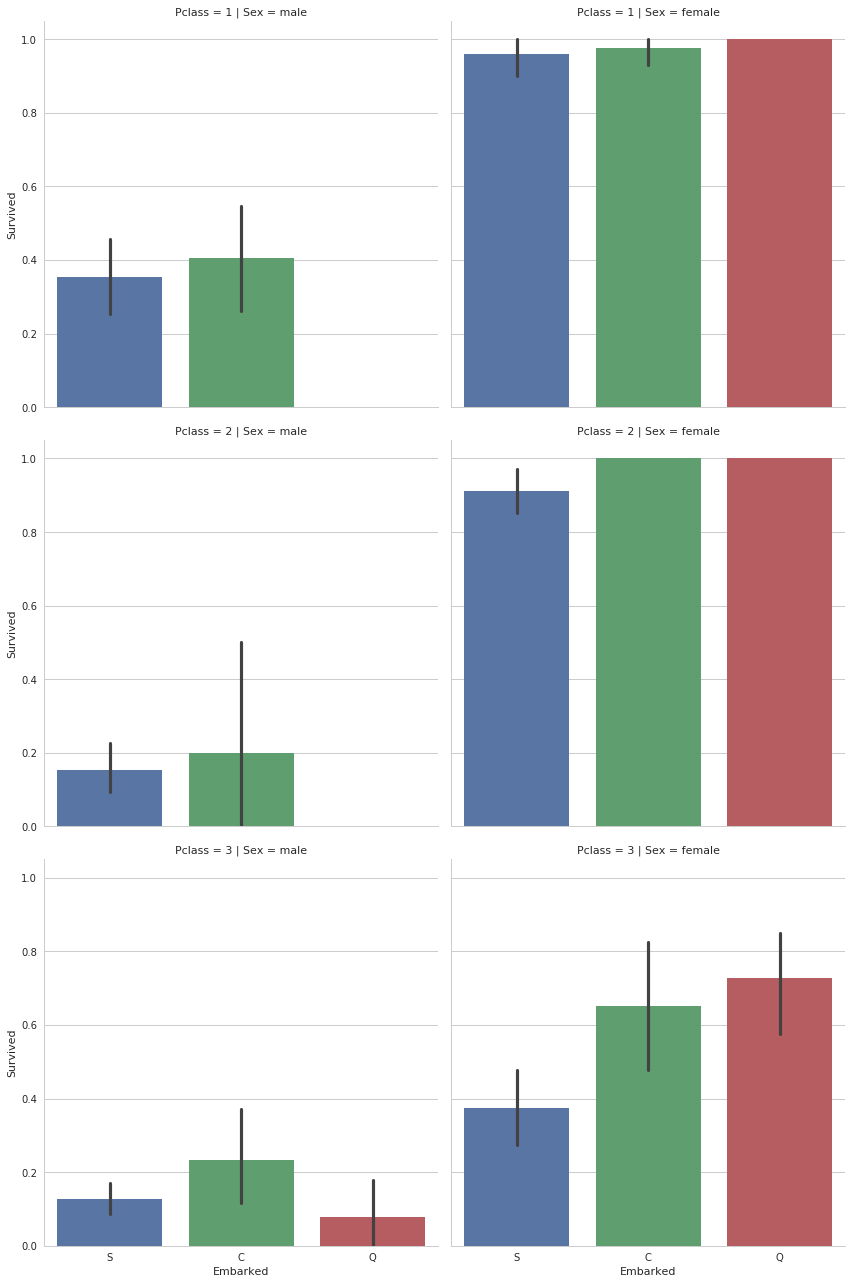

In [185]:
sns.factorplot(x='Embarked', y='Survived', data=train_df, col='Sex', row='Pclass', kind='bar', size=6)
plt.show()

## 3.8. SibSp Analysis

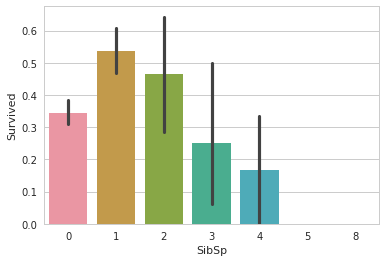

In [186]:
sns.barplot(x='SibSp', y='Survived', data=train_df)
plt.show()

In [187]:
train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

## 3.9. Parch Analysis

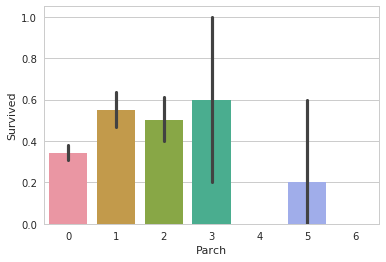

In [188]:
sns.barplot(x='Parch', y='Survived', data=train_df)
plt.show()

In [189]:
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

## 3.10. Age Analysis

In [190]:
train_df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

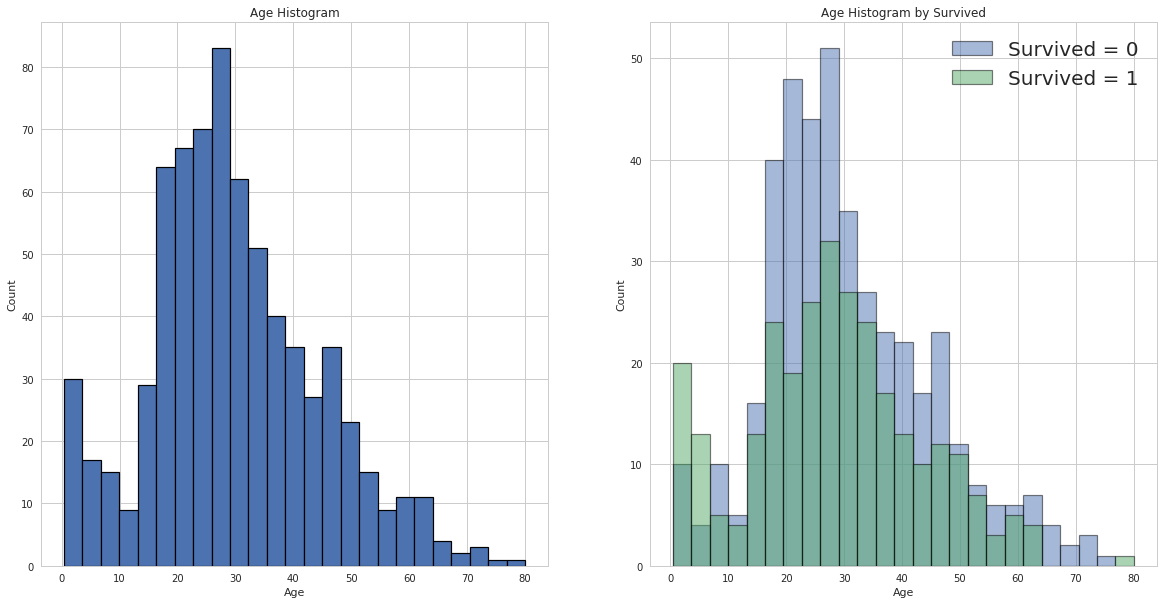

In [191]:
_, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))
_, bins = np.histogram(train_df['Age'].dropna(), bins=25)
ax1.hist(train_df['Age'].dropna(), bins=bins, edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')
ax1.set_title('Age Histogram')
ax2.hist(train_df.loc[train_df.Survived == 0, 'Age'].dropna(), bins=bins, edgecolor='black', linewidth=1.2, alpha=0.5, label='Survived = 0')
ax2.hist(train_df.loc[train_df.Survived == 1, 'Age'].dropna(), bins=bins, edgecolor='black', linewidth=1.2, alpha=0.5, label='Survived = 1')
ax2.set_xlabel('Age')
ax2.set_ylabel('Count')
ax2.set_title('Age Histogram by Survived')
plt.legend(loc='best', prop={'size': 20})
plt.show()

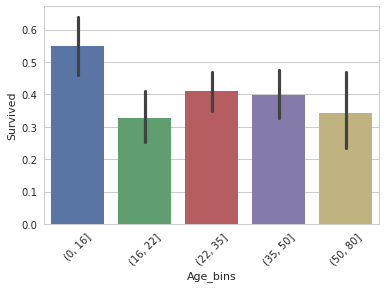

In [192]:
bins = [0, 16, 22, 35, 50, 80]
train_df['Age_bins'] = pd.cut(train_df['Age'], bins)

sns.barplot(x='Age_bins', y='Survived', data=train_df)
plt.xticks(rotation=45)
plt.show()

train_df = train_df.drop(['Age_bins'], axis=1)

## 3.11. Fare Analysis

In [193]:
train_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

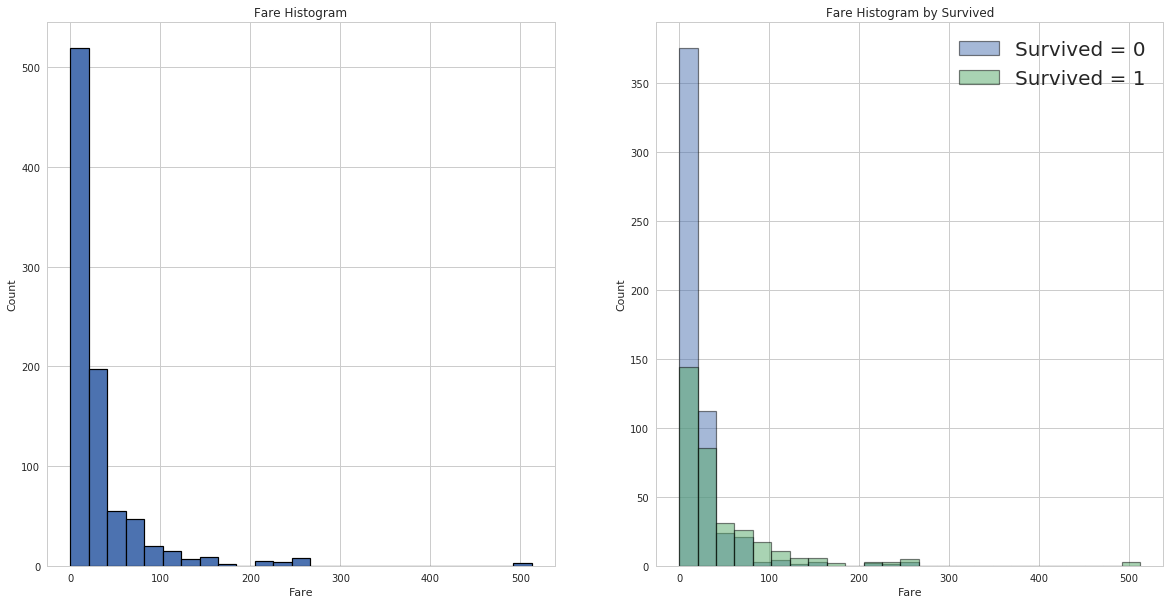

In [194]:
_, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))
_, bins = np.histogram(train_df['Fare'], bins=25)
ax1.hist(train_df['Fare'].dropna(), bins=bins, edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Fare')
ax1.set_ylabel('Count')
ax1.set_title('Fare Histogram')
ax2.hist(train_df.loc[train_df.Survived == 0, 'Fare'].dropna(), bins=bins, edgecolor='black', linewidth=1.2, alpha=0.5, label='Survived = 0')
ax2.hist(train_df.loc[train_df.Survived == 1, 'Fare'].dropna(), bins=bins, edgecolor='black', linewidth=1.2, alpha=0.5, label='Survived = 1')
ax2.set_xlabel('Fare')
ax2.set_ylabel('Count')
ax2.set_title('Fare Histogram by Survived')
plt.legend(loc='best', prop={'size': 20})
plt.show()

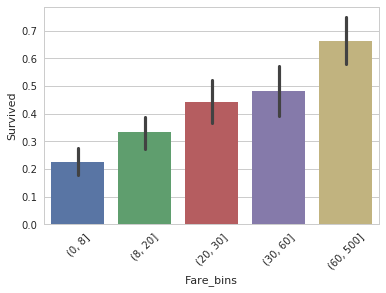

In [195]:
bins = [0, 8, 20, 30, 60, 500]
train_df['Fare_bins'] = pd.cut(train_df['Fare'], bins)

sns.barplot(x='Fare_bins', y='Survived', data=train_df)
plt.xticks(rotation=45)
plt.show()

train_df = train_df.drop(['Fare_bins'], axis=1)

# 4. Feature Engineering

In this stage of the process we are going to extract information from the Name variable in order to generate a new variable called Title. Apart from this, dummy variables will be generated from categorical variables. Finally, to evaluate how much the performance increases (or decreases) because of Title, two sets of variables will be generated, one including this new variable (features_new) and the other without taking it into account (features_old).

In [196]:
# Concatenate training and test data

full_data = pd.concat([train_df.drop('Survived', axis=1), test_df], axis=0)
labels = train_df['Survived']


# Extract Title variable

full_data['Title'] = full_data['Name'].apply(lambda x: re.sub('(.*, )|(\\..*)', '', x))
full_data['Title'].replace('Mlle', 'Miss', inplace=True)
full_data['Title'].replace('Ms', 'Miss', inplace=True)
full_data['Title'].replace('Mme', 'Mrs', inplace=True)
full_data['Title'] = full_data['Title'].apply(lambda x: 'Rare' if x not in ['Mr', 'Miss', 'Mrs', 'Master'] else x)

# KNN mean imputation

def knn_imputation(df, col):
    
    # Extract features and target variable
    
    y = df[col].values
    X = df.drop([col], axis=1).values
    missings_indices = np.isnan(y)
    train_indices = np.logical_not(missings_indices)
    X_train, y_train, X_missings = X[train_indices, :], y[train_indices], X[missings_indices, :]
    
    
    # KNN regression set up

    pipe_knn = make_pipeline(StandardScaler(), PCA(random_state=42), KNeighborsRegressor())


    params_grid = [{'pca__n_components' : np.arange(1, 10 + 1),
                    'kneighborsregressor__n_neighbors' : np.arange(1,21)}]


    # Predict and return
    
    y[missings_indices] = GridSearchCV(pipe_knn, param_grid=params_grid, cv=10, n_jobs=-1).fit(X_train, y_train).predict(X_missings)
    
    return pd.Series(y, index=df.index)
    
       
full_data = full_data.drop(['Name', 'Ticket', 'Cabin'], axis=1)
full_data['Pclass'] = full_data['Pclass'].astype('str')
full_data = pd.get_dummies(full_data)
full_data['Age'] = knn_imputation(full_data, 'Age')


# Reconstruct train and test data

features_train = full_data[:train_df.shape[0]]
features_test = full_data[train_df.shape[0]:]

print('FEATURES TRAIN:\n')
print(features_train.info())

print()

print('FEATURES TEST:\n')
print(features_test.info())

FEATURES TRAIN:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 17 columns):
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
Pclass_1        891 non-null uint8
Pclass_2        891 non-null uint8
Pclass_3        891 non-null uint8
Sex_female      891 non-null uint8
Sex_male        891 non-null uint8
Embarked_C      891 non-null uint8
Embarked_Q      891 non-null uint8
Embarked_S      891 non-null uint8
Title_Master    891 non-null uint8
Title_Miss      891 non-null uint8
Title_Mr        891 non-null uint8
Title_Mrs       891 non-null uint8
Title_Rare      891 non-null uint8
dtypes: float64(2), int64(2), uint8(13)
memory usage: 46.1 KB
None

FEATURES TEST:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 17 columns):
Age             418 non-null float64
SibSp           418 non-null int64
Parch          

In [197]:
features_train.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
PassengerId,,,,,,,,,,,,,,,,,
1,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,0,0,1,0,0
2,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,0,0,0,1,0
3,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,0,1,0,0,0
4,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,0,0,0,1,0
5,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0,0,1,0,0


In [198]:
features_test.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
PassengerId,,,,,,,,,,,,,,,,,
892,34.5,0,0,7.8292,0,0,1,0,1,0,1,0,0,0,1,0,0
893,47.0,1,0,7.0000,0,0,1,1,0,0,0,1,0,0,0,1,0
894,62.0,0,0,9.6875,0,1,0,0,1,0,1,0,0,0,1,0,0
895,27.0,0,0,8.6625,0,0,1,0,1,0,0,1,0,0,1,0,0
896,22.0,1,1,12.2875,0,0,1,1,0,0,0,1,0,0,0,1,0


# 5. Supervised Machine Learning

Now we will fed the features to several machine learning algorithms. First of all, the dataset will be splitted into a training and a test set in order to estimate the performance of each model for previously unseen data. To come up with the optimal hyperparameters for each model, Grid Search will be used.

## 5.1. Set up

In [199]:
# Create aux classes and functions

class HelperClass:
    
    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)
        
    def fit_score(self, est):
        return est.fit(self.X_train, self.y_train).score(self.X_test, self.y_test)
    
    
def evaluate_models(X, y, grids, names):
    
    helper = HelperClass(X, y)
    scores = []
    params = {}

    for grid, name in zip(grids, names):
        scores.append((name, helper.fit_score(grid)))
        params[name] = grid.best_params_
    
    return scores, params


def print_results(scores):
    
    for item in scores:
        print('Score of {} Model: {}'.format(*item))


# Logistic Regression set up

pipe_log = make_pipeline(StandardScaler(), LogisticRegression())

params_grid = [{'logisticregression__penalty' : ['l1', 'l2'],
                'logisticregression__C' : [.01, .1, 1, 10, 100]}]

grid_log = GridSearchCV(pipe_log, param_grid=params_grid, cv=10, n_jobs=-1)


# Linear SVC set up

pipe_linear_svc = make_pipeline(StandardScaler(), LinearSVC())

params_grid = [{'linearsvc__C' : [.01, .1, 1, 10, 100],
                'linearsvc__loss' : ['hinge', 'squared_hinge']}]
              
grid_linear_svc = GridSearchCV(pipe_linear_svc, param_grid=params_grid, cv=10, n_jobs=-1)


# Kernelized SVC set up

pipe_kernel_svc = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

params_grid = [{'svc__kernel' : ['rbf'],
                'svc__C' : [.01, .1, 1, 10, 100],
                'svc__gamma' : [.001, .01, 0.1, 1, 10]}]
              
grid_kernel_svc = GridSearchCV(pipe_kernel_svc, param_grid=params_grid, cv=10, n_jobs=-1)


# Decision Tree set up

pipe_tree = make_pipeline(DecisionTreeClassifier())

params_grid = [{'decisiontreeclassifier__criterion' : ['gini', 'entropy'],
                'decisiontreeclassifier__max_depth' : np.arange(3, 11)}]

grid_tree = GridSearchCV(pipe_tree, param_grid=params_grid, cv=10, n_jobs=-1)


# Random Forest set up

pipe_forest = make_pipeline(RandomForestClassifier(random_state=42, n_estimators=1000))

grid_forest = GridSearchCV(pipe_forest, param_grid=[{'randomforestclassifier__n_estimators' : [1000]}], cv=2, n_jobs=-1)


# Gradient Boosted Regression Tree set up

pipe_gradient = make_pipeline(GradientBoostingClassifier(random_state=42, n_estimators=100))

params_grid = [{'gradientboostingclassifier__learning_rate' : [.001, .01, .1, 1],
                'gradientboostingclassifier__max_depth': [1, 2, 3, 4, 5]}]

grid_gradient = GridSearchCV(pipe_gradient, param_grid=params_grid, cv=10, n_jobs=-1)


# KNN set up

pipe_knn = make_pipeline(StandardScaler(), PCA(random_state=42), KNeighborsClassifier())


params_grid = [{'pca__n_components' : np.arange(1, 10 + 1),
               'kneighborsclassifier__n_neighbors' : np.arange(1,21)}]


grid_knn = GridSearchCV(pipe_knn, param_grid=params_grid, cv=10, n_jobs=-1)


# Put grids and names in a list

grids = [grid_log, grid_linear_svc, grid_kernel_svc, grid_tree, grid_forest, grid_gradient, grid_knn]
names = ['Logistic Regression', 'Linear Kernel SVM', 'Gaussian Kernel SVM', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'KNN']


## 5.2. Get scores for each model

In [200]:
X_train = features_train.values
y_train = labels.values

scores, params = evaluate_models(X_train, y_train, grids, names)

print('RESULTS:\n')
print_results(scores)
      

RESULTS:

Score of Logistic Regression Model: 0.8491620111731844
Score of Linear Kernel SVM Model: 0.8435754189944135
Score of Gaussian Kernel SVM Model: 0.8212290502793296
Score of Decision Tree Model: 0.8324022346368715
Score of Random Forest Model: 0.8212290502793296
Score of Gradient Boosting Model: 0.8212290502793296
Score of KNN Model: 0.7932960893854749


In [201]:
def create_submissions(grids, names, X_train, y_train, X_test):
    
    for grid, name in zip(grids, names):
        y_pred = grid.best_estimator_.fit(X_train, y_train).predict(X_test)
        pd.DataFrame(y_pred, columns=['Survived'], index=features_test.index).reset_index().to_csv('{}.csv'.format(name), index=False)

X_test = features_test.values
create_submissions(grids, names, X_train, y_train, X_test)

In [202]:
params

{'Decision Tree': {'decisiontreeclassifier__criterion': 'entropy',
  'decisiontreeclassifier__max_depth': 3},
 'Gaussian Kernel SVM': {'svc__C': 10,
  'svc__gamma': 0.01,
  'svc__kernel': 'rbf'},
 'Gradient Boosting': {'gradientboostingclassifier__learning_rate': 0.1,
  'gradientboostingclassifier__max_depth': 3},
 'KNN': {'kneighborsclassifier__n_neighbors': 20, 'pca__n_components': 5},
 'Linear Kernel SVM': {'linearsvc__C': 10, 'linearsvc__loss': 'hinge'},
 'Logistic Regression': {'logisticregression__C': 0.1,
  'logisticregression__penalty': 'l2'},
 'Random Forest': {'randomforestclassifier__n_estimators': 1000}}